# Neural Network
Neural network is a supervised machine learning algorithm used to predict a target variable (y) based on independent variables (X). They consist of interconnected nodes called neurons that learn and represent patterns within the data. By adjusting weights and biases, the network minimizes the difference between predicted and actual values during training. When making predictions, input data is processed through the network, producing a summarized prediction that captures complex relationships and nonlinearities in the data.

In this demo, we will implement a simple multi-layer sigmoid neuron network to classify hand written digits. For historical reasons, this is sometimes also called multilayer perceptrons (MLP), despite being made up of sigmoid neurons, not perceptrons 

### Import libraries and initialize random generator

In [1]:
import random
import time
import numpy as np
random.seed(0)
np.random.seed(0)
np.set_printoptions(threshold=10) # printing format

### load the MNIST image data
Load the MNIST data as a tuple containing the training data, 
the validation data, and the test data.

In [2]:
import pickle
with open('/kaggle/input/mnist-handwritten-digits/mnist.pkl', 'rb') as file:
    data = pickle._Unpickler(file)
    data.encoding = 'latin1'
    training_data, validation_data, test_data = data.load()

The ``training_data`` is returned as a tuple with two entries.
The first entry contains the actual training images.  

In [3]:
training_inputs, training_results = training_data
"""
#same as:
training_inputs =training_data[0]
training_results =training_data[1]
"""

'\n#same as:\ntraining_inputs =training_data[0]\ntraining_results =training_data[1]\n'

This is a
numpy ndarray with 50,000 entries.  Each entry is, in turn, a
numpy ndarray with 784 values, representing the 28 * 28 = 784
pixels in a single MNIST image.

One example image:

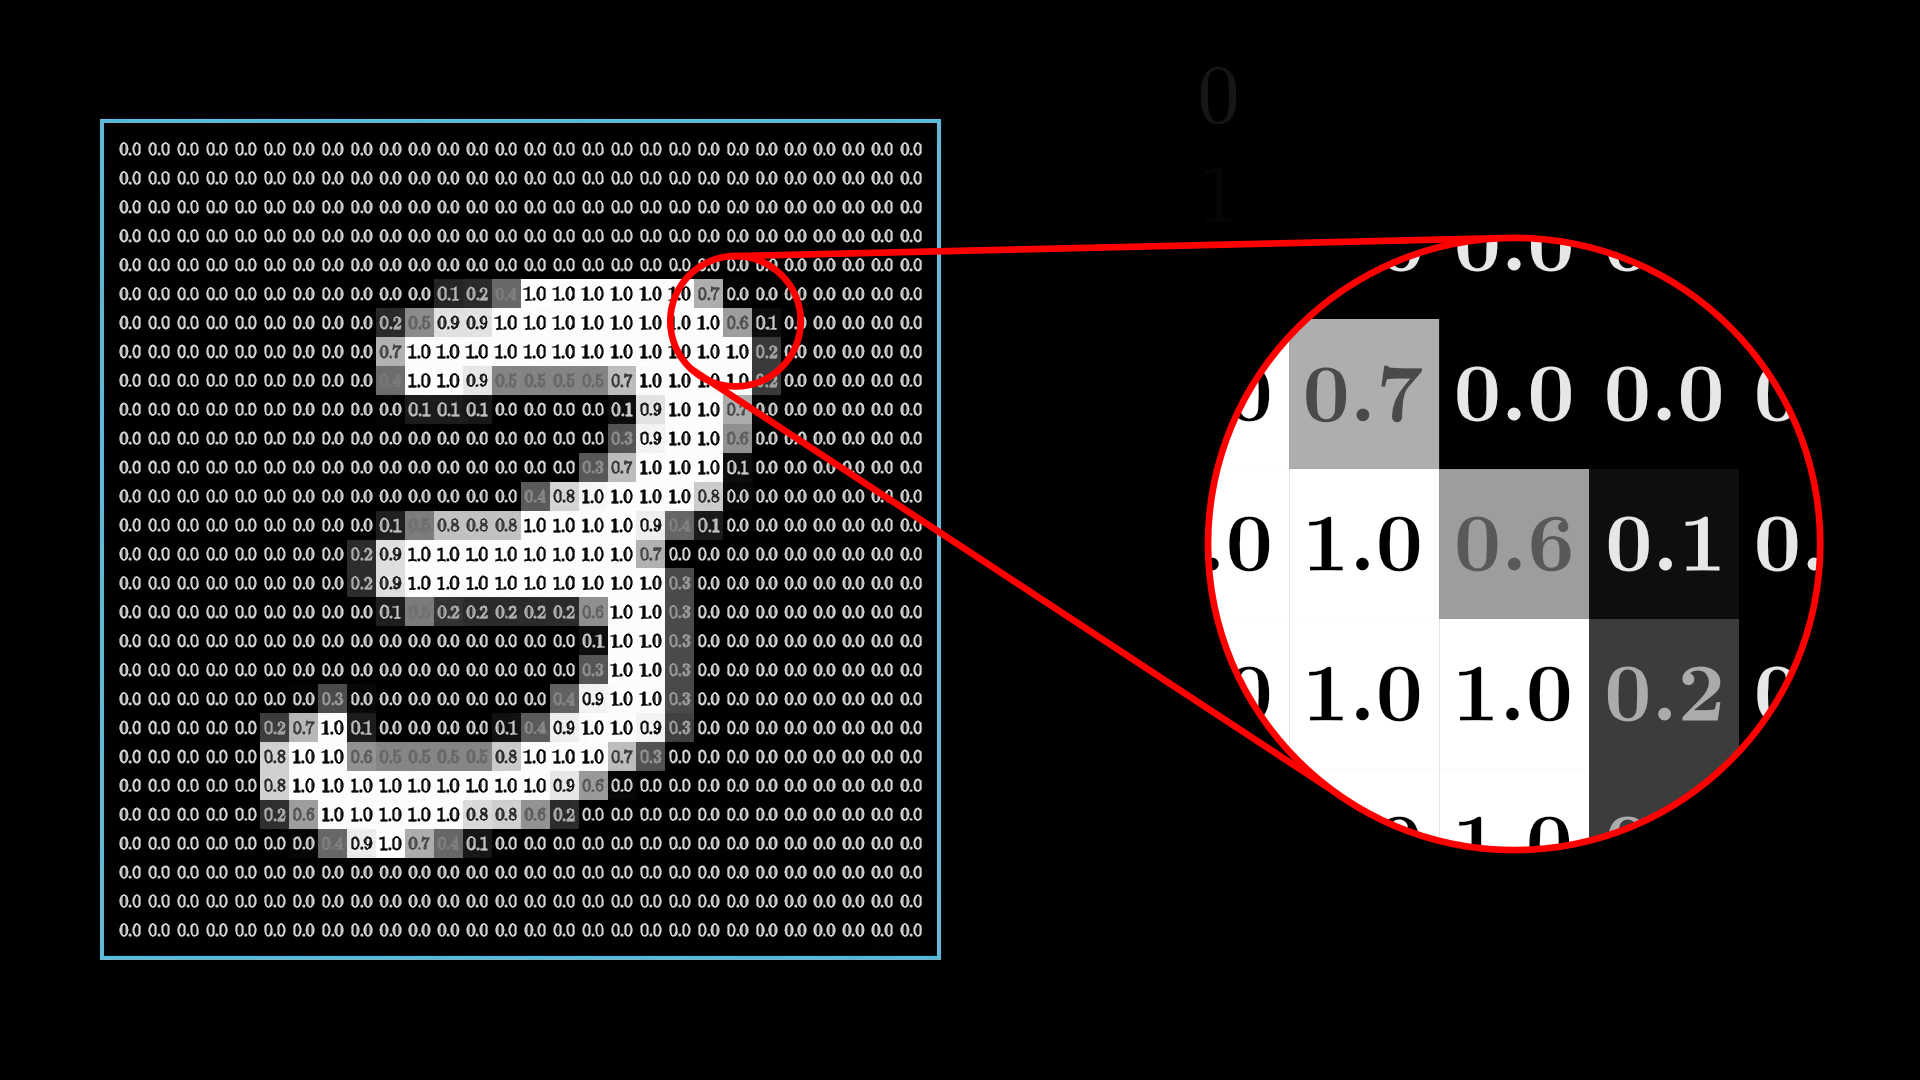


In [4]:
display(training_inputs)
display(training_inputs.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

(50000, 784)

The second entry in the ``training_data`` tuple is a numpy ndarray
containing 50,000 entries.  Those entries are just the digit
values (0...9) for the corresponding images contained in the first
entry of the tuple.



In [5]:
display(training_results)
display(training_results.shape)

array([5, 0, 4, ..., 8, 4, 8])

(50000,)

The ``validation_data`` and ``test_data`` are the same, except
each contains only 10,000 images.

In [6]:
print(validation_data[0].shape,validation_data[1].shape)
print(test_data[0].shape,test_data[1].shape)

(10000, 784) (10000,)
(10000, 784) (10000,)


### Vectorizing the labels
This convert categorical labels (such as digits 0-9) into a vector numerical format. Later, our model will not directly predict the digits of handwritten images. Rather, our model gives a probability distribution of what digit an image might be. For example, an image of 2 will be [0%,0%, 100%, 0%,0%,0%,0%,0%,0%,0%] meaning it have 100% probability of being a 2, and 0% probability of being other digits. 
By vectorizing the training data, we make later calculations more efficient.

In [7]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    unit_vector = np.zeros((10, 1))
    unit_vector[j] = 1.0
    return unit_vector

In [8]:
#for example:
vectorized_result(2)


array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

now we apply vectorization to every training label. We also reshape the training inputs from row to column vectors

In [9]:
training_set = []
for i in range(50000):
    image_vector = training_inputs[i]
    # convert the row vectors to column vectors (for the purpose of doing matrix multiplications later)
    image_vector = np.reshape(image_vector, (784,1))
    
    image_label = training_results[i]
    # vectorize the image labels
    image_label = vectorized_result(image_label)
    
    training_set.append((image_vector,image_label))

In [10]:
# perform the same operation for validation set and testing set. 
# to save space, the code below is written using Python's list comprehension shortcut. 
# the outcome is the same as the code above, except the labels are NOT vectorized
validation_inputs = [np.reshape(x, (784, 1)) for x in validation_data[0]]
validation_set = list(zip(validation_inputs, validation_data[1]))
test_inputs = [np.reshape(x, (784, 1)) for x in test_data[0]]
test_set = list(zip(test_inputs, test_data[1]))

## Neural Network
Below implements the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation. For the sake of simplicity and readability, the code is not optimized, and omits many desirable performance features. 

The rough idea is:
1. Randomly initialize the weights and biases. 
2. Compute the gradient of the cost function in respect to the weights and biases for EVERY image. (i.e. computing how we should change the weights and biases so that the network is less wrong in EVERY image)
3. Now we know how we should change the weights and biases so that the network is less wrong, we use this gradient to update the weights and biases (minus the weights and biases by the gradients times a tiny number called learning rate)
4. Repeat for as many times as time and computation resource permits

The above is called gradient descent.
However, computing the gradient for EVERY image is often too slow. Therefore, we only use SOME subset of the dataset, which the exact amount is called the mini_batch_size. This is called stochastic gradient descent. 

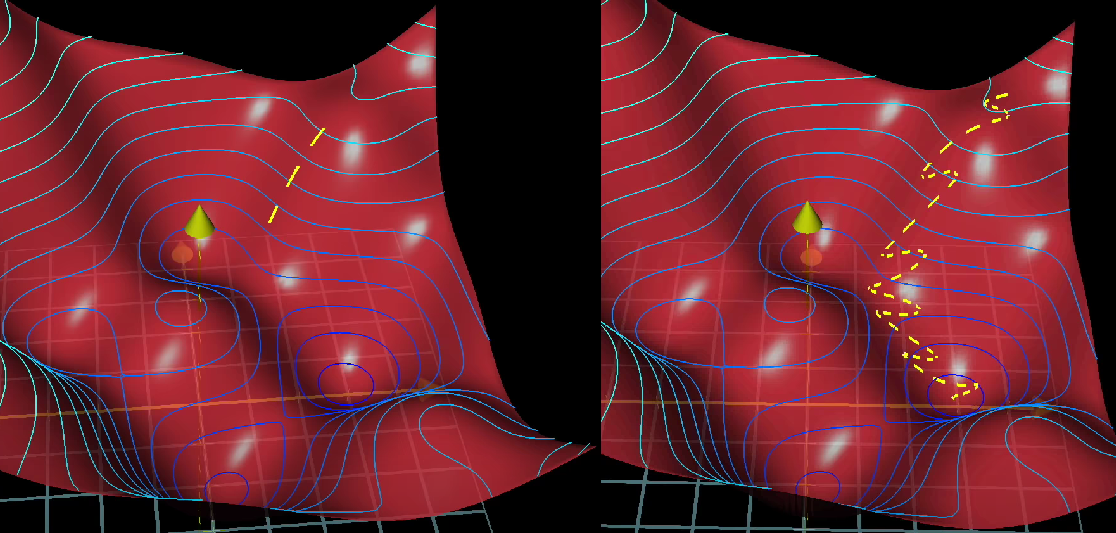

Gradient descent is like a smooth ball rolling down the hill perfectly towards the steepest direction. Stochastic gradient descent is like a dice stumbling down the hill, sometimes rolling side ways, sometimes rolling up, but in general still going down.

### sigmoid function
We will use the sigmoid function as our activation function. It is popular in early NN models for several reason. 
1. It is continuous and differentiable, enabling calculation of gradients.
2. It is non-linear, which means it can solve non-linearly separable problem
3. It's output is between 0 and 1, which stabilize the training process by preventing large, unbounded values from propagating through the network. It also allows for a natural interpretation of the output as a probability.

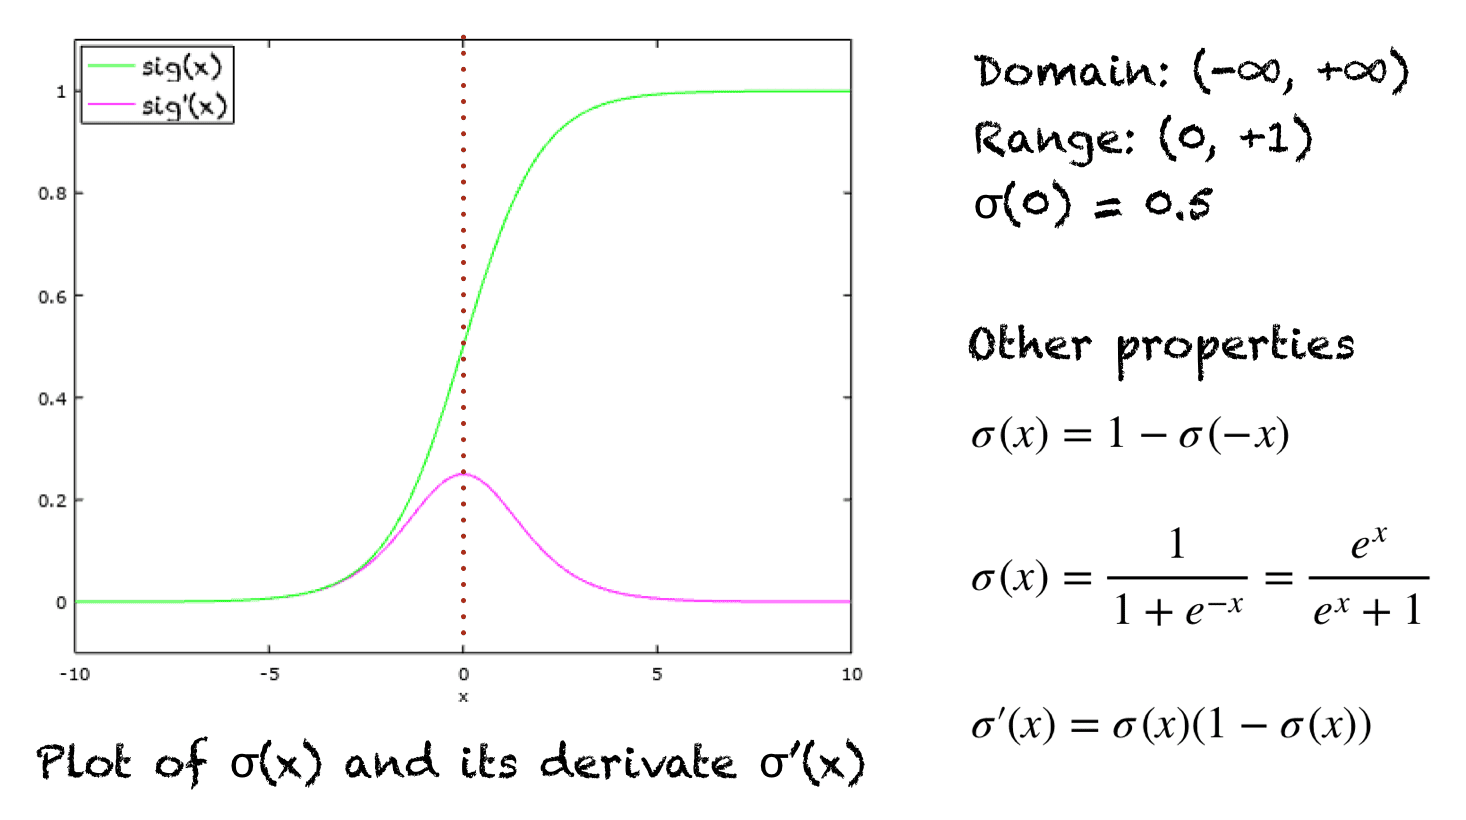

Note: in modern deep neural networks, sigmoid function has been replaced by other functions such as RELU (rectified linear unit).


In [11]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))


### Initialize the network (weights & biases)
We will make a network with 3 layers. The input layer have 784 neurons, the middle layer have 15 neurons, and output layer have 10 neurons.

We chose 3 layers in this demo just to keep the training time quick. Usually, larger networks of more layers will perform better. 

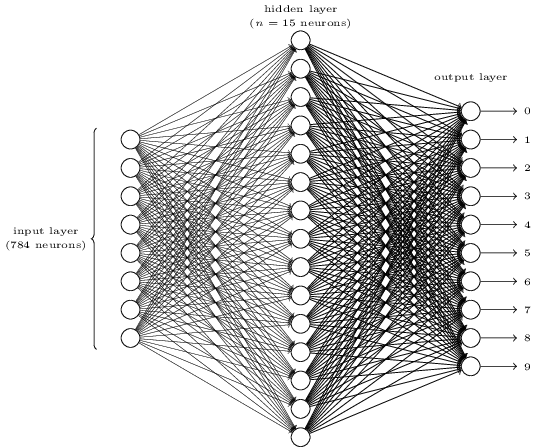

The biases and weights are all initialized randomly, using the Numpy np.random.randn function to generate Gaussian distributions with mean 0 and standard deviation 1. This random initialization gives our stochastic gradient descent algorithm a place to start from. Biases and weights are stored as lists of Numpy matrices.

Since the first layer of neurons is an input layer, we do not set any biases for those neurons, since biases are only ever used in computing the outputs from later layers.


In [12]:
layer1_size, layer2_size, layer3_size = (784, 15, 10)
num_layers = 3

biases = []

# layer 1 bias: first layer of neurons is an input layer, se we don't set any biases for those neurons,
# since biases are only ever used in computing the outputs from later layers.
layer2_bias = np.random.randn(15,1)
biases.append(layer2_bias)
layer3_bias = np.random.randn(10,1)
biases.append(layer3_bias)

weights = []
layer1_to_2_weight = np.random.randn(15,784)
weights.append(layer1_to_2_weight)
layer2_to_3_weight = np.random.randn(10, 15)
weights.append(layer2_to_3_weight)

### Feedforward
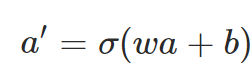

a is the vector of activations of the n-th layer of neurons. To obtain a′ (n+1 th layer),
we multiply a by the weight matrix w, and add the vector b of biases. We then apply the function σ elementwise to every entry in the vector wa+b.

Because we have 3 layers of neurons, we need to apply this process twice (layer1-->2, layer2-->3)

In [13]:
def feedforward(a, biases, weights):
    #layer 1 --> 2
    b = biases[0]
    w = weights[0]
    a_layer2 = sigmoid(np.dot(w, a) + b)
    
    #layer 2 --> 3    
    b = biases[1]
    w = weights[1]
    a_layer3 = sigmoid(np.dot(w, a_layer2) + b)
    return a_layer3


### Evaluating accuracy (to count the amount of correct predictions)


In [14]:
def evaluate(test_data, biases, weights):
    correct_prediction_count = 0
    for x, y in test_data:
        # example: [0, 0, 0.9, 0.05, 0.05, 0, 0,0 ,0,0]
        predicted_y = np.argmax(feedforward(x, biases, weights))
        if predicted_y == y:
            correct_prediction_count +=1    
    return correct_prediction_count

### Stochastic gradient descent
To speed up training, we only use a subset of all the data during one iteration. These subsets are called mini-batches.
In each epoch, we start by randomly shuffling the training data. Then, we slice it into mini-batches. Then for each mini_batch we apply a single step of gradient descent, which updates the network weights and biases according to a single iteration of gradient descent, using just the training data in mini_batch.

In [15]:
def SGD(training_data, num_epochs, mini_batch_size, learning_rate, num_layers, test_data=None):
    #the purpose of SGD is to change the biases and weights
    global biases, weights
    
    n = len(training_data)
    
    for j in range(num_epochs):
        time1 = time.time()
        
        random.shuffle(training_data)
        
        for k in range(0, n, mini_batch_size): # for(int k=0; k<50000; k+=mini_batch_size)
            #slice the dataset into batches
            mini_batch = training_data[k:k + mini_batch_size]
            #apply a single step of gradient descent
            biases, weights = update_mini_batch(mini_batch, learning_rate, biases, weights, num_layers)
        
        time2 = time.time()
        
        count = evaluate(test_data, biases, weights)
        accuracy = count / len(test_data)
        print(f"Epoch {j}: {count} / {len(test_data)}, took {(time2-time1):.2f} seconds")


### Using a minibatch for SGD 
This function computes the gradients for every training image in the mini_batch, and then updating weights and biases appropriately.


In [16]:
def update_mini_batch(mini_batch, learning_rate, biases, weights, num_layers):
    mini_batch_size = len(mini_batch)
    
    # initializes nabla_b and nabla_w, with arrays of zeros, and same shape as the biases and weights.
    """
    simplified version:
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    explicit version:
    """
    nabla_b = []
    nabla_w = []    
    for b in biases:
        nabla_b.append(np.zeros(b.shape))
    for w in weights:
        nabla_w.append(np.zeros(w.shape))
    
    #computes the gradients (of cost function) for every training image in the mini_batch.
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = backprop(x, y, num_layers, biases, weights)
        
        for i in range(len(nabla_b)):
            nabla_b[i] += delta_nabla_b[i]
        
        for i in range(len(nabla_w)):
            nabla_w[i] += delta_nabla_w[i]
    
    # updating weights and biases appropriately:
    # (take a step in the direction opposite to the gradient, with step size proportional to the learning_rate)
    # we divide by mini_batch_size to obtain average
    for i in range(len(weights)):
        weights[i] -= (learning_rate / mini_batch_size) * nabla_w[i]
    for i in range(len(biases)):
        biases[i] -= (learning_rate / mini_batch_size) * nabla_b[i]
    
    return biases, weights


### Backpropagation
The backpropagation algorithm is a fast way of computing the gradient of the cost function. It takes in a single example and returns the gradient of the cost function in respect to the weights and biases. In other words, we give this function an image + label, and the function tells us how the biases and weights should be altered such that the biases and weights can correctly classify this image.

The activation of every layer depends on the previous layer:

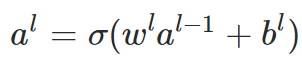

We will name the inside part "weighted input", or z

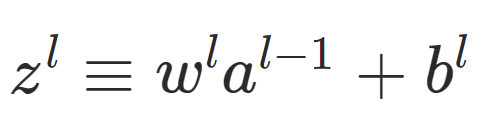

The following are the fundamental equations of back propagation. Proofs can be found here: http://neuralnetworksanddeeplearning.com/chap2.html


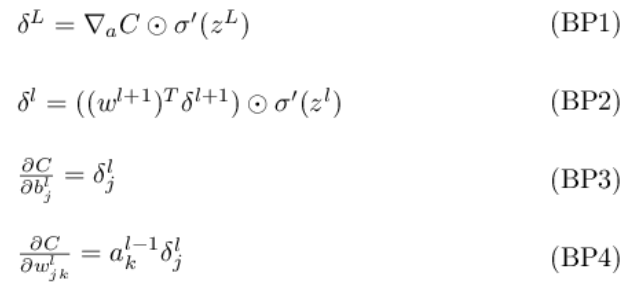


In [17]:
def cost_derivative(output_activations, y):
    return output_activations - y

def backprop(x, y, num_layers, biases, weights):
    """Return a tuple "(nabla_b, nabla_w)" representing the
    gradient for the cost function C_x.  "nabla_b" and
    "nabla_w" are layer-by-layer lists of numpy arrays, similar
    to "self.biases" and "self.weights"."""

    # initializes nabla_b and nabla_w, with arrays of zeros, and same shape as the biases and weights.
    """
    simplified version:
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    explicit version:"""
    nabla_b = []
    nabla_w = []
    for b in biases:
        nabla_b.append(np.zeros(b.shape))
    for w in weights:
        nabla_w.append(np.zeros(w.shape))
    
    activation = x 
    activation_layers = [x]  #list to store all the activations, layer by layer
    z_layers = []   #list to store all the weighted inputs, layer by layer
    
    # calculate the activations and weighted inputs for all layers
    # if there are 3 layers, the activations needs to back propagate twice
    # (layer3 --> layer2,  layer2 --> layer1)
    for i in range(2): 
        b = biases[i]
        w = weights[i]
    
        z = np.dot(w, activation) + b
        z_layers.append(z)
        activation = sigmoid(z)
        activation_layers.append(activation)
    
    # apply equation BP1 and BP2, which finds the gradient for the last layer
    delta = cost_derivative(activation_layers[-1], y) * sigmoid_prime(z_layers[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activation_layers[-2].transpose())
    
    # apply equation BP3 and BP4, which finds the gradient for all previous layer
    for l in range(2, num_layers):
        delta = np.dot(weights[-l + 1].T, delta) * sigmoid_prime(z_layers[-l])
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activation_layers[-l - 1].T)
    
    return nabla_b, nabla_w

In [21]:
epochs = 100
mini_batch_size = 5
learning_rate = 0.2
SGD(training_set, epochs, mini_batch_size, learning_rate, num_layers,test_set)


Epoch 0: 8959 / 10000, took 16.57 seconds
Epoch 1: 9040 / 10000, took 15.74 seconds
Epoch 2: 9066 / 10000, took 16.13 seconds
Epoch 3: 9107 / 10000, took 16.12 seconds
Epoch 4: 9124 / 10000, took 16.56 seconds
Epoch 5: 9167 / 10000, took 15.59 seconds
Epoch 6: 9161 / 10000, took 15.89 seconds
Epoch 7: 9183 / 10000, took 15.64 seconds
Epoch 8: 9204 / 10000, took 16.02 seconds
Epoch 9: 9218 / 10000, took 15.63 seconds


In [19]:
accuracy = evaluate(validation_set, biases, weights) / len(validation_set)
print("accuracy",accuracy)

accuracy 0.8885


### Exercises
1. Change the middle layer of the network from 15 neurons to 30 neurons, and observe the result
2. Change the network to 4 layers, with two middle layers both with 30 neurons. 
3. Explain how does learning_rate affect the training process
4. Explain how does epoch count affect the training process
5. Choose another activation function here, and replace the sigmoid & sigmoid_price functions with it.
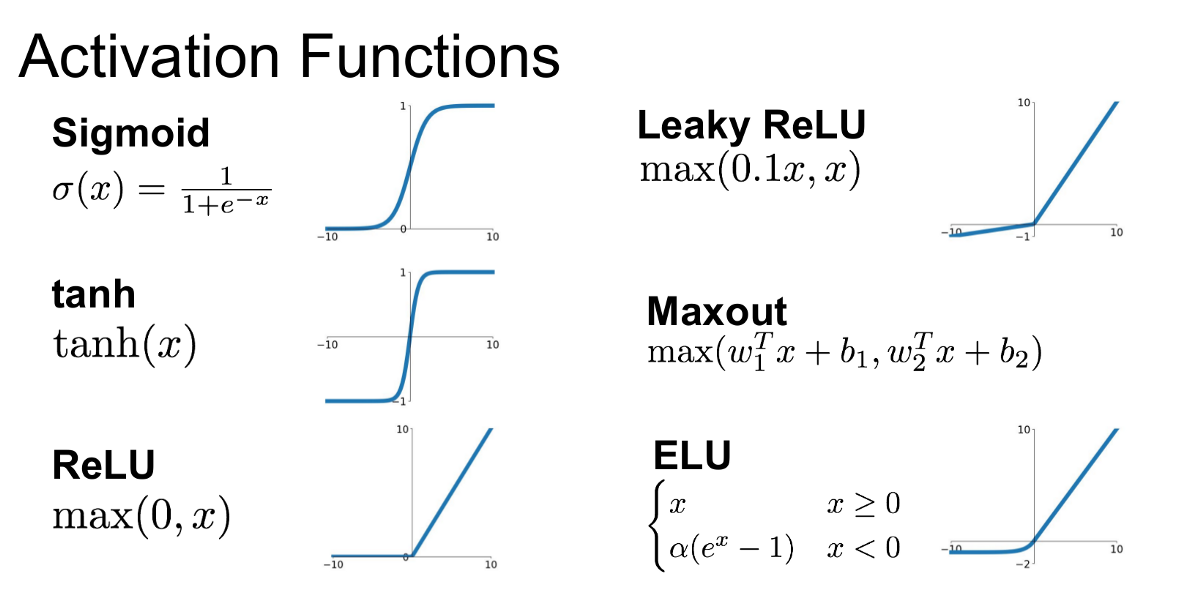


In [20]:
def relu(z):
    # exercise: code here 
    pass
def relu_prime(z):
    # exercise: code here 
    pass
"""
SOLUTION:

def relu(z):
    return np.maximum(0, z)

def relu_prime(z):
    return np.where(z > 0, 1, 0)
"""

'\nSOLUTION:\n\ndef relu(z):\n    return np.maximum(0, z)\n\ndef relu_prime(z):\n    return np.where(z > 0, 1, 0)\n'

### References
- http://neuralnetworksanddeeplearning.com/
- https://machinelearningmastery.com/a-gentle-introduction-to-sigmoid-function/
- https://www.3blue1brown.com/topics/neural-networks
- https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31?gi=7c68464316bd